# Spark on the KDD99 dataset #

Our objective in this project is to create a network intrusion detection system  that can identify which network flow is malicious  and which is not. We will use the dataset from here - http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html

This is a multiclass classification problem.

The features are as follows:

* duration: continuous.
* protocol_type: symbolic.
* service: symbolic.
* flag: symbolic.
* src_bytes: continuous.
* dst_bytes: continuous.
* land: symbolic.
* wrong_fragment: continuous.
* urgent: continuous.
* hot: continuous.
* num_failed_logins: continuous.
* logged_in: symbolic.
* num_compromised: continuous.
* root_shell: continuous.
* su_attempted: continuous.
* num_root: continuous.
* num_file_creations: continuous.
* num_shells: continuous.
* num_access_files: continuous.
* num_outbound_cmds: continuous.
* is_host_login: symbolic.
* is_guest_login: symbolic.
* count: continuous.
* srv_count: continuous.
* serror_rate: continuous.
* srv_serror_rate: continuous.
* rerror_rate: continuous.
* srv_rerror_rate: continuous.
* same_srv_rate: continuous.
* diff_srv_rate: continuous.
* srv_diff_host_rate: continuous.
* dst_host_count: continuous.
* dst_host_srv_count: continuous.
* dst_host_same_srv_rate: continuous.
* dst_host_diff_srv_rate: continuous.
* dst_host_same_src_port_rate: continuous.
* dst_host_srv_diff_host_rate: continuous.
* dst_host_serror_rate: continuous.
* dst_host_srv_serror_rate: continuous.
* dst_host_rerror_rate: continuous.
* dst_host_srv_rerror_rate: continuous.

All possible target classifications are as follows:

* back,
* buffer_overflow,
* ftp_write,
* guess_passwd,
* imap,
* ipsweep,
* land,
* loadmodule,
* multihop,
* neptune,
* nmap,
* normal,
* perl,
* phf,
* pod,
* portsweep,
* rootkit,
* satan,
* smurf,
* spy,
* teardrop,
* warezclient,
* warezmaster.

## Step 1.1: Download the dataset 

In [1]:
# Precautionary step: remove all pre existing kdd files
# !rm -rf kdd*

!wget -q -O ../datasets/kddtrain.gz \
http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz

!wget -q -O ../datasets/kddtest.gz \
http://kdd.ics.uci.edu/databases/kddcup99/corrected.gz
    
# A list of features
!wget -q -O ../datasets/kddnames \
http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
    
!gunzip ../datasets/kdd*gz

In [2]:
# Preview the data
# Our target is the last variable
!head -3 ../datasets/kddtrain

0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,0.11,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,239,486,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,19,19,1.00,0.00,0.05,0.00,0.00,0.00,0.00,0.00,normal.
0,tcp,http,SF,235,1337,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,29,29,1.00,0.00,0.03,0.00,0.00,0.00,0.00,0.00,normal.


## Step 1.2: Get the feature variables and target variable 

In [7]:
# The features are in the kddnames file 
# http://kdd.ics.uci.edu/databases/kddcup99/kddcup.names
import pprint
with open('../datasets/kddnames', 'r') as fh:
    header = [line.split(':')[0] 
              for line in fh.read().splitlines()][1:]

header.append('target')

print "Num features:", len(header)-1
print '\nThe feature set with the target in the last spot are as follows:\n'
pprint.pprint(header)

Num features: 41

The feature set with the target in the last spot are as follows:

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'target']


## Step 1.3 Create 2 RDDs for training and testing data

In [8]:
# Training data
train_rdd = sc.textFile('file:///home/vagrant/datasets/kddtrain')

# Testing data
test_rdd = sc.textFile('file:///home/vagrant/datasets/kddtest')

## Step 2: Data preprocessing ##

In this step we will parse each line of each file to create a Dataframe. The steps followed are as follows:

* Split each line of the CSV into separate fields
* Cast each numerical value to float, and each text value to string.
* Remove the dot at the end of each line.

In [9]:
# Preprocessing function
# Example:
# 0,tcp,http,SF,181,5450,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,8,8,0.00,0.00,0.00,0.00,1.00,0.00,0.00,9,9,1.00,0.00,
# 0.11,0.00,0.00,0.00,0.00,0.00,normal.
def line_parser(line):   
    def piece_parser(piece):
            # Cast int to float
            if "." in piece or piece.isdigit():
                return float(piece)
            else:
                return piece
    # Split each line into separate fields
    return [piece_parser(piece) for piece in line[:-1].split(',')]

# Training dataframe
train_df = sqlContext.createDataFrame(train_rdd.map(line_parser), header)

# Testing dataframe
test_df = sqlContext.createDataFrame(test_rdd.map(line_parser), header)

In [10]:
# Spark actions
# Total number of rows in training and testing sets
print "Train observations:", train_df.count()
print "Test observations:", test_df.count()
'''
Our test set has close to 500,000 rows, along with 41 features. That is 20 million values.
'''

Train observations: 494021
Test observations: 311029


In [12]:
# Study schema of the dataframe
train_df.printSchema()

root
 |-- duration: double (nullable = true)
 |-- protocol_type: string (nullable = true)
 |-- service: string (nullable = true)
 |-- flag: string (nullable = true)
 |-- src_bytes: double (nullable = true)
 |-- dst_bytes: double (nullable = true)
 |-- land: double (nullable = true)
 |-- wrong_fragment: double (nullable = true)
 |-- urgent: double (nullable = true)
 |-- hot: double (nullable = true)
 |-- num_failed_logins: double (nullable = true)
 |-- logged_in: double (nullable = true)
 |-- num_compromised: double (nullable = true)
 |-- root_shell: double (nullable = true)
 |-- su_attempted: double (nullable = true)
 |-- num_root: double (nullable = true)
 |-- num_file_creations: double (nullable = true)
 |-- num_shells: double (nullable = true)
 |-- num_access_files: double (nullable = true)
 |-- num_outbound_cmds: double (nullable = true)
 |-- is_host_login: double (nullable = true)
 |-- is_guest_login: double (nullable = true)
 |-- count: double (nullable = true)
 |-- srv_count: do

## Step 3: Feature engineering

In [13]:
'''
There are 4 categorical features: protocol_type, service, flag, target.

As we are using a tree based classifier we will encode the text at each level to a number for each variable.

We will use StringIndexer for this purpose. 
'''
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer

# Define categorical variables
cols_categorical = ["protocol_type", "service", "flag","target"]
preproc_stages = []

# Chain four StringIndexer objects together in a cascade, each operating on a specific column of the dataframe
# outputting a datframe with an additional column with the _cat suffix
for col in cols_categorical:
    out_col = col + "_cat"
    preproc_stages.append(
        StringIndexer(inputCol = col, 
                      outputCol = out_col, 
                      handleInvalid = "skip"))

# Feed the preproc_stages list into the pipeline.
pipeline = Pipeline(stages = preproc_stages)
# Fit all the indexers
indexer = pipeline.fit(train_df)

# Call transform on the new fitted object
train_num_df = indexer.transform(train_df)
test_num_df = indexer.transform(test_df)

In [17]:
# Pipeline stages
print 'The pipeline stages are: \n'
pprint.pprint(pipeline.getStages())
print "\n"
print pipeline
# The indexer is object has the 'Model' suffix
'''
In scikit-learn, fit and transform are called on the same object. In spark, the fit method creates a new object which
has the Model suffix. This object is then fed into the transform method.
'''
print 'The fitted object that we get from the fit function that we feed into the transform method is : ', indexer

The pipeline stages are: 

[StringIndexer_4addb847a07a0d501912,
 StringIndexer_4bf0bc7e3dd167b37e67,
 StringIndexer_4062bda3fe2b5a161625,
 StringIndexer_40c6abbe0492f347fa42]


Pipeline_4ab99e967d2e9ac010f7
The fitted object that we get from the fit function that we feed into the transform method is :  PipelineModel_4b39b7043f58418535b5


In [18]:
'''
Checking the first object(first line in the CSV file) after passing through the pipeline.

There are 4 extra columns with values: protocol_type_cat=1.0, service_cat=2.0, flag_cat=0.0, target_cat=2.0
'''
print "First observation, after the 4 StringIndexers:\n"
pprint.pprint(train_num_df.first())

First observation, after the 4 StringIndexers:

Row(duration=0.0, protocol_type=u'tcp', service=u'http', flag=u'SF', src_bytes=181.0, dst_bytes=5450.0, land=0.0, wrong_fragment=0.0, urgent=0.0, hot=0.0, num_failed_logins=0.0, logged_in=1.0, num_compromised=0.0, root_shell=0.0, su_attempted=0.0, num_root=0.0, num_file_creations=0.0, num_shells=0.0, num_access_files=0.0, num_outbound_cmds=0.0, is_host_login=0.0, is_guest_login=0.0, count=8.0, srv_count=8.0, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=9.0, dst_host_srv_count=9.0, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=0.11, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, target=u'normal', protocol_type_cat=1.0, service_cat=2.0, flag_cat=0.0, target_cat=2.0)


In [20]:
# Extract the numerical columns
# Replace categorical text columns with their numerical counterparts
# Remove the target variable and its numerical counterpart as we want just the features
features_header = set(header) \
                - set(cols_categorical) \
                | set([c + "_cat" for c in cols_categorical]) \
                - set(["target", "target_cat"])

features_header = list(features_header)

print 'The feature list with all numerical values is as follows: \n'
pprint.pprint(features_header)
print "Total numerical features:", len(features_header)

The feature list with all numerical values is as follows: 

['num_access_files',
 'src_bytes',
 'srv_count',
 'num_outbound_cmds',
 'rerror_rate',
 'urgent',
 'protocol_type_cat',
 'dst_host_same_srv_rate',
 'duration',
 'dst_host_diff_srv_rate',
 'srv_serror_rate',
 'is_host_login',
 'wrong_fragment',
 'serror_rate',
 'num_compromised',
 'is_guest_login',
 'dst_host_rerror_rate',
 'dst_host_srv_serror_rate',
 'hot',
 'dst_host_srv_count',
 'logged_in',
 'srv_rerror_rate',
 'dst_host_srv_diff_host_rate',
 'srv_diff_host_rate',
 'dst_host_same_src_port_rate',
 'root_shell',
 'service_cat',
 'su_attempted',
 'dst_host_count',
 'num_file_creations',
 'flag_cat',
 'count',
 'land',
 'same_srv_rate',
 'dst_bytes',
 'num_shells',
 'dst_host_srv_rerror_rate',
 'num_root',
 'diff_srv_rate',
 'num_failed_logins',
 'dst_host_serror_rate']
Total numerical features: 41


### Build the feature matrix ##

In [21]:
# Create feature vectors for feeding into the ML algorithm

from pyspark.mllib.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

# We store the features in 'features'
assembler = VectorAssembler(inputCols = features_header,
                            outputCol = "features")

# Get the training data using the features and target variable
Xy_train = (assembler.transform(train_num_df)
                     .select("features", "target_cat"))

# Get the testing data using the features and target variable
Xy_test = (assembler.transform(test_num_df)
                    .select("features", "target_cat"))

In [22]:
# Preview what our training data now looks like:
Xy_train.first()

Row(features=SparseVector(41, {1: 181.0, 2: 8.0, 6: 1.0, 7: 1.0, 19: 9.0, 20: 1.0, 24: 0.11, 26: 2.0, 28: 9.0, 31: 8.0, 33: 1.0, 34: 5450.0}), target_cat=2.0)

## Step 4: Training a learner ##

We will be using a random forest for this multiclass classification problem.

In [23]:
'''
Parameter check:
featuresCol: the column containing the feature matrix
labelCol:    the column containing the target label
seed:        random seed to make the experiment replicable
maxBins:     max number of bins to use for the splitting point in each node of the tree

Default value for number of trees is 20, default depth is 5

The classifier creates 3 output columns in the dataframe:
rawPrediction: to store the prediction score for each possible label
probability:   to store the likelihood of each label
prediction:    the most probable label
'''
from pyspark.ml.classification import RandomForestClassifier

clf = RandomForestClassifier(labelCol="target_cat", 
                             featuresCol="features", 
                             maxBins=100, 
                             seed=101)
fit_clf = clf.fit(Xy_train)

In [24]:
# View the classifier
print "Random forest classifier spec: \n", fit_clf

Random forest classifier spec: 
RandomForestClassificationModel (uid=rfc_b32f22f2ff2a) with 20 trees


## Step 5: Make predictions ##

In [25]:
# Transform the classifier to make predictions
Xy_pred_train = fit_clf.transform(Xy_train)
Xy_pred_test = fit_clf.transform(Xy_test)

In [27]:
print "First observation after classification stage:"
pprint.pprint(Xy_pred_test.first())
'''
Viewing the first line of our predictions for test set:

Row(features = SparseVector(41, {1: 105.0, 
                                 2: 1.0, 
                                 6: 2.0, 
                                 7: 1.0, 
                                 9: 0.01, 
                                 19: 254.0, 
                                 26: 1.0, 
                                 28: 255.0, 
                                 31: 1.0, 
                                 33: 1.0, 
                                 34: 146.0}), 
                            target_cat=2.0, 
                            rawPrediction = DenseVector([0.0283, 
                                                         0.0112, 
                                                         19.3474, 
                                                         0.0677, 
                                                         0.0251, 
                                                         0.1414, 
                                                         0.0357, 
                                                         0.1194, 
                                                         0.1309, 
                                                         0.041, 
                                                         0.0257, 
                                                         0.0079, 
                                                         0.0046, 
                                                         0.0004, 
                                                         0.0029, 
                                                         0.0016, 
                                                         0.002, 
                                                         0.0023, 
                                                         0.0013, 
                                                         0.0008, 
                                                         0.0012, 
                                                         0.0006, 
                                                         0.0006]), 
                             probability = DenseVector([0.0014, 
                                                        0.0006, 
                                                        0.9674, 
                                                        0.0034, 
                                                        0.0013, 
                                                        0.0071, 
                                                        0.0018, 
                                                        0.006, 
                                                        0.0065, 
                                                        0.002,
                                                        0.0013, 
                                                        0.0004, 
                                                        0.0002, 
                                                        0.0, 
                                                        0.0001, 
                                                        0.0001, 
                                                        0.0001, 
                                                        0.0001, 
                                                        0.0001, 
                                                        0.0, 
                                                        0.0001, 
                                                        0.0, 
                                                        0.0]), 
                            prediction = 2.0)
'''

First observation after classification stage:
Row(features=SparseVector(41, {1: 105.0, 2: 1.0, 6: 2.0, 7: 1.0, 9: 0.01, 19: 254.0, 26: 1.0, 28: 255.0, 31: 1.0, 33: 1.0, 34: 146.0}), target_cat=2.0, rawPrediction=DenseVector([0.0283, 0.0112, 19.3474, 0.0677, 0.0251, 0.1414, 0.0357, 0.1194, 0.1309, 0.041, 0.0257, 0.0079, 0.0046, 0.0004, 0.0029, 0.0016, 0.002, 0.0023, 0.0013, 0.0008, 0.0012, 0.0006, 0.0006]), probability=DenseVector([0.0014, 0.0006, 0.9674, 0.0034, 0.0013, 0.0071, 0.0018, 0.006, 0.0065, 0.002, 0.0013, 0.0004, 0.0002, 0.0, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0, 0.0001, 0.0, 0.0]), prediction=2.0)


## Step 6: Evaluate the classifier ##

In [30]:
'''
We will be using the F score.
'''

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol = "target_cat", 
                                              predictionCol = "prediction", 
                                              metricName = "f1")

print "F1-score train set:", evaluator.evaluate(Xy_pred_train)
print "F1-score test set:", evaluator.evaluate(Xy_pred_test)

F1-score train set: 0.991904372002
F1-score test set: 0.966840043466


## All in one step ##

In [34]:
# Define stages
full_stages = preproc_stages + [assembler, clf]

# Set the pipeline with the stages
full_pipeline = Pipeline(stages = full_stages)

# Fit the model on the training data
full_model = full_pipeline.fit(train_df)

# Make predictions on the test data
predictions = full_model.transform(test_df)

# Evaluate performance of the model
print "F1-score test set:", evaluator.evaluate(predictions)

F1-score test set: 0.966840043466


## Step 7: Visualise our output ##

In [35]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
 
# Normalized confusion matrix of the classification results
def plot_confusion_matrix(cm):
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm_normalized, 
               interpolation='nearest', 
               cmap=plt.cm.Blues)
    plt.title('Normalized Confusion matrix')
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

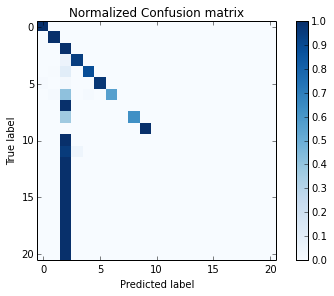

In [36]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Transform dataframe to RDD
metrics = MulticlassMetrics(predictions
                            .select("prediction", "target_cat")
                            .rdd)
# Convert matrix to array
conf_matrix = metrics.confusionMatrix().toArray()
plot_confusion_matrix(conf_matrix)

## Step 8: Understanding our results ##

As we can see in our plot, our classifier does a good job of classifying the most popular classes correctly.

We will now resample each class and then make predictions.

In [37]:
# How many classifications of each type are there?
train_composition = train_df.groupBy("target")
                            .count()
                            .rdd
                            .collectAsMap()
train_composition

{u'back': 2203,
 u'buffer_overflow': 30,
 u'ftp_write': 8,
 u'guess_passwd': 53,
 u'imap': 12,
 u'ipsweep': 1247,
 u'land': 21,
 u'loadmodule': 9,
 u'multihop': 7,
 u'neptune': 107201,
 u'nmap': 231,
 u'normal': 97278,
 u'perl': 3,
 u'phf': 4,
 u'pod': 264,
 u'portsweep': 1040,
 u'rootkit': 10,
 u'satan': 1589,
 u'smurf': 280790,
 u'spy': 2,
 u'teardrop': 979,
 u'warezclient': 1020,
 u'warezmaster': 20}

The range of targets go from 2203 to 0. To mitigate this  we can oversample rare classes and subsample popular classes.

We will create a training dataset where each class is represented at least 1000 times, up to 25,000.

## Step 8.1: Oversampling and subsampling ##

In [39]:
# Oversample rare classes and subsample popular classes.
def set_sample_rate_between_vals(cnt, the_min, the_max):
    if the_min <= cnt <= the_max:
        # no sampling
        return 1
    # Oversample popular classes
    elif cnt < the_min:
        # Oversampling: return many times the same observation
        return the_min/float(cnt)

    else:
        # Subsample rare classes
        # Subsampling: sometime don't return it
        return the_max/float(cnt)
        
sample_rates = {k:set_sample_rate_between_vals(v, 1000, 25000) 
                for k,v in train_composition.iteritems()} 
print 'Sample rates for the targets are: \n'
pprint.pprint(sample_rates)

Sample rates for the targets are: 

{u'back': 1,
 u'buffer_overflow': 33.333333333333336,
 u'ftp_write': 125.0,
 u'guess_passwd': 18.867924528301888,
 u'imap': 83.33333333333333,
 u'ipsweep': 1,
 u'land': 47.61904761904762,
 u'loadmodule': 111.11111111111111,
 u'multihop': 142.85714285714286,
 u'neptune': 0.23320677978750198,
 u'nmap': 4.329004329004329,
 u'normal': 0.2569954152017928,
 u'perl': 333.3333333333333,
 u'phf': 250.0,
 u'pod': 3.787878787878788,
 u'portsweep': 1,
 u'rootkit': 100.0,
 u'satan': 1,
 u'smurf': 0.08903450977598917,
 u'spy': 500.0,
 u'teardrop': 1.0214504596527068,
 u'warezclient': 1,
 u'warezmaster': 50.0}


In [40]:
# Broadcast to all nodes
bc_sample_rates = sc.broadcast(sample_rates)


def map_and_sample(el, rates):
    rate = rates.value[el['target']]
    if rate > 1:
        return [el]*int(rate)
    else:
        import random
        return [el] if random.random() < rate else []

sampled_train_df = (train_df
                   .flatMap(
                     lambda x: map_and_sample(x, bc_sample_rates))
                   .toDF()
                   .cache())

In [41]:
# Check number of lines in the new sampled training set
sampled_train_df.count()

96901

In [42]:
# Preview of the data in the new sampled training set
sampled_train_df.first()

Row(duration=0.0, protocol_type=u'tcp', service=u'http', flag=u'SF', src_bytes=219.0, dst_bytes=1337.0, land=0.0, wrong_fragment=0.0, urgent=0.0, hot=0.0, num_failed_logins=0.0, logged_in=1.0, num_compromised=0.0, root_shell=0.0, su_attempted=0.0, num_root=0.0, num_file_creations=0.0, num_shells=0.0, num_access_files=0.0, num_outbound_cmds=0.0, is_host_login=0.0, is_guest_login=0.0, count=6.0, srv_count=6.0, serror_rate=0.0, srv_serror_rate=0.0, rerror_rate=0.0, srv_rerror_rate=0.0, same_srv_rate=1.0, diff_srv_rate=0.0, srv_diff_host_rate=0.0, dst_host_count=39.0, dst_host_srv_count=39.0, dst_host_same_srv_rate=1.0, dst_host_diff_srv_rate=0.0, dst_host_same_src_port_rate=0.03, dst_host_srv_diff_host_rate=0.0, dst_host_serror_rate=0.0, dst_host_srv_serror_rate=0.0, dst_host_rerror_rate=0.0, dst_host_srv_rerror_rate=0.0, target=u'normal')

## Step 8.2: Pipeline to make prediction on new sampled dataset ##

In [43]:
# Fit the sampled data
full_model = full_pipeline.fit(sampled_train_df)

# Make predictions on the test data
predictions = full_model.transform(test_df)

# Evaluate performance
print "F1-score test set:", evaluator.evaluate(predictions)

F1-score test set: 0.96846934656


### Build another pipeline `refined_pipeline` and substitute the final stage with a new classifier with 50 trees.

In [44]:
# Define the classifier
clf = RandomForestClassifier(numTrees=50, 
                             maxBins=100, 
                             seed=101,
                             labelCol="target_cat", 
                             featuresCol="features")

# Get the stages
stages = full_pipeline.getStages()[:-1]
stages.append(clf)

# Set the stages into the pipeline
refined_pipeline = Pipeline(stages=stages)

# Fit the model usng the training data
refined_model = refined_pipeline.fit(sampled_train_df)

# Make predictions on the test data
predictions = refined_model.transform(test_df)

# F1 score
print "F1-score test set:", evaluator.evaluate(predictions)

F1-score test set: 0.967655096048


## Step 8.3: Cross Validation ##

In [46]:
# Cache the training data
pipeline_to_clf = Pipeline(stages = preproc_stages + [assembler]).fit(sampled_train_df)

# Cache the trained model
train = pipeline_to_clf.transform(sampled_train_df).cache()
test = pipeline_to_clf.transform(test_df)

## Step 8.4 Hyperparameter optimization ##

We need:

* Grid map of parameters - ParamGridBuilder
* Cross validation procedure - CrossValidator

In [47]:

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Define the classifier
rf = RandomForestClassifier(cacheNodeIds=True, 
                            seed=101, 
                            labelCol="target_cat", 
                            featuresCol="features", 
                            maxBins=100)

# Hyperparameter optimization - maximum depth and number of trees
grid = (ParamGridBuilder() 
        .addGrid(rf.maxDepth, [3, 6, 9, 12]) 
        .addGrid(rf.numTrees, [20, 50]) 
        .build())

# Define cross validator
cv = CrossValidator(estimator = rf, 
                    estimatorParamMaps = grid, 
                    evaluator = evaluator, 
                    numFolds=3)

# Fit model on training set
cvModel = cv.fit(train)

## Step 8.5: Make predictions ##

In [48]:
# Make predictions
predictions = cvModel.transform(test)
print "F1-score test set:", evaluator.evaluate(predictions)

F1-score test set: 0.970347508684


## Step 8.6: Plot confusion matrix ##

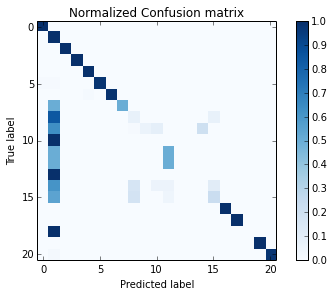

In [49]:
# Metrics calculated on predictions vs target_cat
metrics = MulticlassMetrics(predictions.select("prediction", "target_cat").rdd)

# Cast values to array
conf_matrix = metrics.confusionMatrix().toArray()

# Plot matrix
plot_confusion_matrix(conf_matrix)

Now we are able discover a wider variety of attacks, even the unpopular ones.

## Step 9: Memory cleanup ##

In [50]:
# Unpersist all data objects
bc_sample_rates.unpersist()
sampled_train_df.unpersist()
train.unpersist()

DataFrame[duration: double, protocol_type: string, service: string, flag: string, src_bytes: double, dst_bytes: double, land: double, wrong_fragment: double, urgent: double, hot: double, num_failed_logins: double, logged_in: double, num_compromised: double, root_shell: double, su_attempted: double, num_root: double, num_file_creations: double, num_shells: double, num_access_files: double, num_outbound_cmds: double, is_host_login: double, is_guest_login: double, count: double, srv_count: double, serror_rate: double, srv_serror_rate: double, rerror_rate: double, srv_rerror_rate: double, same_srv_rate: double, diff_srv_rate: double, srv_diff_host_rate: double, dst_host_count: double, dst_host_srv_count: double, dst_host_same_srv_rate: double, dst_host_diff_srv_rate: double, dst_host_same_src_port_rate: double, dst_host_srv_diff_host_rate: double, dst_host_serror_rate: double, dst_host_srv_serror_rate: double, dst_host_rerror_rate: double, dst_host_srv_rerror_rate: double, target: string, 